# Amazon forest analysis from satellite images.


#### Data obtained from the kaggle competition https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/

## Visualize whats happening in the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# base_path = '/media/anant/data/amazon_from_space/'
base_path = '/media/avemuri/DEV/Data/amazon_from_space/'

In [3]:
train_df = pd.read_csv(base_path+'train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### Plot the frequency of each label

In [4]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in train_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'haze', 'blow_down', 'clear', 'cultivation', 'water', 'road', 'bare_ground', 'primary', 'conventional_mine', 'selective_logging', 'partly_cloudy', 'habitation', 'blooming', 'slash_burn', 'agriculture', 'cloudy', 'artisinal_mine'}


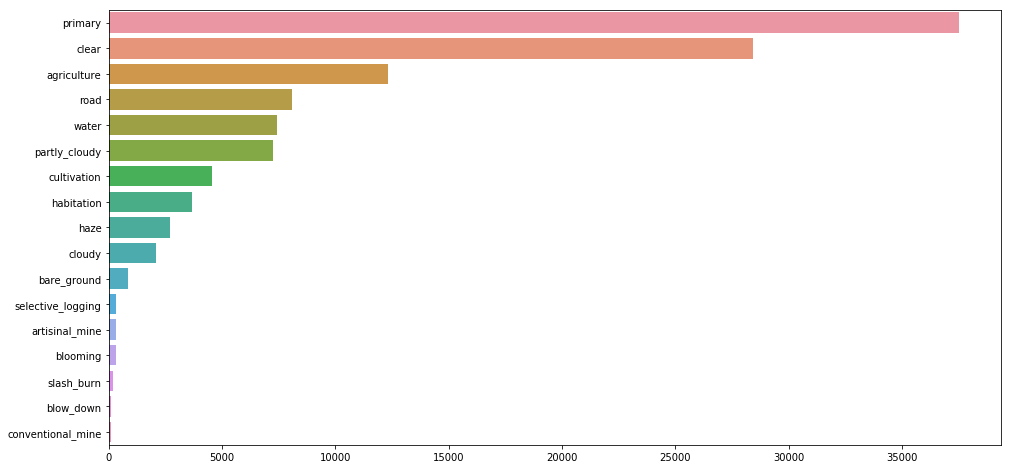

In [5]:
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Imports for training

In [10]:
import glob
import cv2
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, fbeta_score
from tqdm import tqdm_notebook, tqdm


import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

40479


## Get data

### Get data as numpy array

In [21]:
def get_data(base_path=base_path, folder_name='train-jpg', csv_file='train_v2.csv'):
    
    X = []
    y = []
    df_train = pd.read_csv(base_path+csv_file)

    flatten = lambda l: [item for sublist in l for item in sublist]
    labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

    label_map = {l: i for i, l in enumerate(labels)}
    inv_label_map = {i: l for l, i in label_map.items()}

    for f, tags in tqdm(df_train.values, miniters=1000):
        img = cv2.imread(base_path+folder_name+'/'+'{}.jpg'.format(f))
        targets = np.zeros(17)
        for t in tags.split(' '):
            targets[label_map[t]] = 1 
        X.append(cv2.resize(img, (32, 32)))
        #y.append(targets)
    
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df_train['tags'].str.split()).astype(np.float32)
    
    # y = np.array(y, np.uint8)
    X = np.array(X, np.float16) / 255.
                         
    return X, y

In [22]:
X, y = get_data()

SPLIT = 0.2
dataset_size = len(image_list)
indices = list(range(dataset_size))
split = int(np.floor(SPLIT * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

x_train, y_train = X[train_indices], y[train_indices]
x_valid, y_valid = X[val_indices], y[val_indices]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

100%|██████████| 40479/40479 [01:10<00:00, 571.39it/s]


(32384, 32, 32, 3) (32384, 17) (8095, 32, 32, 3) (8095, 17)


### Load data as data generator

In [23]:
image_list = [f for f in glob.glob(base_path+'train-jpg/*.jpg')]
labels_df = pd.read_csv(base_path+'train_v2.csv')
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels_df['tags'].str.split()).astype(np.float32)

SPLIT = 0.2
dataset_size = len(image_list)
indices = list(range(dataset_size))
split = int(np.floor(SPLIT * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
print(len(train_indices), len(val_indices))

32384 8095


In [24]:
def image_generator(image_list, labels, batch_size=64, selection_indices=None):
    
    while True:
        # Select files (paths/indices) for the batch
        if selection_indices is None:
            batch_paths = np.random.choice(a=np.arange(len(image_list)), 
                                            size=batch_size, replace=False)
        else:
            batch_paths = np.random.choice(a=selection_indices, 
                                            size=batch_size, replace=False)

        batch_input = []
        batch_output = [] 
        
        # Read in each input, perform preprocessing and get labels
        for index in batch_paths:
            image = cv2.resize(cv2.imread(image_list[index]), (32, 32)) / 255.
            # input = preprocess_input(image=input)
            batch_input += [ image ]
            batch_output += [ labels[index] ]
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

In [25]:
BATCH_SIZE = 256
train_datagen = image_generator(image_list, labels, batch_size=BATCH_SIZE, selection_indices=train_indices)
valid_datagen = image_generator(image_list, labels, batch_size=BATCH_SIZE, selection_indices=val_indices)

In [26]:
for i in range(4):
    x, y = next(train_datagen)
    print(x.shape, y.shape)
    x, y = next(valid_datagen)
    print(x.shape, y.shape)

(256, 32, 32, 3) (256, 17)
(256, 32, 32, 3) (256, 17)
(256, 32, 32, 3) (256, 17)
(256, 32, 32, 3) (256, 17)
(256, 32, 32, 3) (256, 17)
(256, 32, 32, 3) (256, 17)
(256, 32, 32, 3) (256, 17)
(256, 32, 32, 3) (256, 17)


## Model definition

In [27]:
def create_simple_model(image_input_size=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=image_input_size))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    
    return model

## Metrics

In [28]:
class KerasMetrics:
	def precision(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		predicted_positives = k.backend.sum(k.backend.round(k.backend.clip(y_pred, 0, 1)))
		precision = true_positives / (predicted_positives + k.backend.epsilon())
		return precision

	def recall(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		possible_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1)))
		recall = true_positives / (possible_positives + k.backend.epsilon())
		return recall

	def fbeta_score(self, y_true, y_pred, beta=2):
		if beta < 0:
			raise ValueError('The lowest choosable beta is zero (only precision).')

		if k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1))) == 0:
			return 0

		p = self.precision(y_true, y_pred)
		r = self.recall(y_true, y_pred)
		bb = beta ** 2
		fbeta_score = (1 + bb) * (p * r) / (bb * p + r + k.backend.epsilon())
		return fbeta_score

In [29]:
keras_metrics = KerasMetrics()

## Training

### Train - from data as numpy array

In [30]:
model = create_simple_model()

W0917 16:37:05.932328 140048735446848 deprecation.py:506] From /media/avemuri/DEV/software/anaconda3/envs/TF/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [31]:
# We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
optim = k.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy', keras_metrics.fbeta_score])

W0917 16:37:10.792775 140048735446848 deprecation.py:323] From /media/avemuri/DEV/software/anaconda3/envs/TF/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
datagen = k.preprocessing.image.ImageDataGenerator()
# width_shift_range=0.2,
#                                                    height_shift_range=0.2,
#                                                    vertical_flip=True)

# datagen.fit(x_train)

In [33]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              steps_per_epoch=len(x_train)/BATCH_SIZE, epochs=100,
                              validation_data=(x_valid, y_valid))

Epoch 1/100
127/126 [==============================] - 5s 40ms/step - loss: 0.3006 - acc: 0.8872 - fbeta_score: 0.5834 - val_loss: 0.2386 - val_acc: 0.9066 - val_fbeta_score: 0.6085
Epoch 2/100
127/126 [==============================] - 3s 21ms/step - loss: 0.2394 - acc: 0.9078 - fbeta_score: 0.6034 - val_loss: 0.2113 - val_acc: 0.9156 - val_fbeta_score: 0.6369
Epoch 3/100
127/126 [==============================] - 3s 21ms/step - loss: 0.2253 - acc: 0.9121 - fbeta_score: 0.6279 - val_loss: 0.2059 - val_acc: 0.9176 - val_fbeta_score: 0.6432
Epoch 4/100
127/126 [==============================] - 3s 21ms/step - loss: 0.2142 - acc: 0.9146 - fbeta_score: 0.6423 - val_loss: 0.2010 - val_acc: 0.9177 - val_fbeta_score: 0.6765
Epoch 5/100
127/126 [==============================] - 3s 22ms/step - loss: 0.2096 - acc: 0.9158 - fbeta_score: 0.6487 - val_loss: 0.1939 - val_acc: 0.9211 - val_fbeta_score: 0.6488
Epoch 6/100
127/126 [==============================] - 3s 26ms/step - loss: 0.1992 - acc: 

### Train - data as custom datagenerator

In [37]:
model = create_simple_model()

In [41]:
# We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
optim = k.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy', keras_metrics.fbeta_score])

In [42]:
history = model.fit_generator(train_datagen,
                              steps_per_epoch=len(train_indices)/BATCH_SIZE, epochs=10,
                              validation_data=valid_datagen,
                              validation_steps=len(val_indices)/BATCH_SIZE, use_multiprocessing=True)

Epoch 1/10
127/126 [==============================] - 52s 406ms/step - loss: 13.4707 - acc: 0.8927 - fbeta_score: 0.5900 - val_loss: 0.2564 - val_acc: 0.9070 - val_fbeta_score: 0.6103
Epoch 2/10
127/126 [==============================] - 48s 378ms/step - loss: 0.2582 - acc: 0.9052 - fbeta_score: 0.6045 - val_loss: 0.2569 - val_acc: 0.9070 - val_fbeta_score: 0.6103
Epoch 3/10
127/126 [==============================] - 48s 380ms/step - loss: 0.2561 - acc: 0.9052 - fbeta_score: 0.6045 - val_loss: 0.2568 - val_acc: 0.9070 - val_fbeta_score: 0.6103
Epoch 4/10
127/126 [==============================] - 48s 378ms/step - loss: 0.2573 - acc: 0.9045 - fbeta_score: 0.6022 - val_loss: 0.2563 - val_acc: 0.9070 - val_fbeta_score: 0.6103
Epoch 5/10
127/126 [==============================] - 48s 379ms/step - loss: 0.2565 - acc: 0.9049 - fbeta_score: 0.6035 - val_loss: 0.2564 - val_acc: 0.9070 - val_fbeta_score: 0.6103
Epoch 6/10
 20/126 [===>..........................] - ETA: 16s - loss: 0.2620 - acc:

Process Keras_worker_ForkPoolWorker-9:
Traceback (most recent call last):
  File "/media/avemuri/DEV/software/anaconda3/envs/TF/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/media/avemuri/DEV/software/anaconda3/envs/TF/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/media/avemuri/DEV/software/anaconda3/envs/TF/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/media/avemuri/DEV/software/anaconda3/envs/TF/lib/python3.7/site-packages/tensorflow/python/keras/utils/data_utils.py", line 828, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "<ipython-input-24-1df731828cd8>", line 17, in image_generator
    image = cv2.resize(cv2.imread(image_list[index]), (32, 32)) / 255.
KeyboardInterrupt


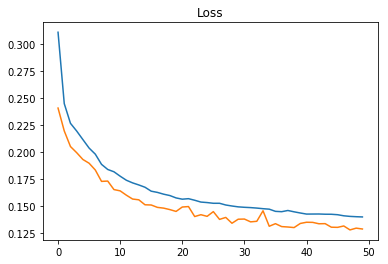

In [49]:
_ = plt.plot(history.history['loss'], label='Train')
_ = plt.plot(history.history['val_loss'], label='Validation')
_ = plt.title('Loss')

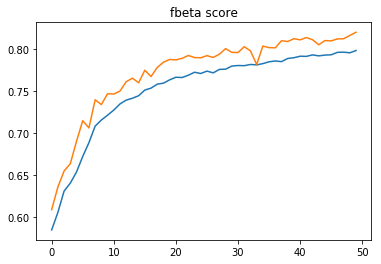

In [50]:
_ = plt.plot(history.history['fbeta_score'], label='Train')
_ = plt.plot(history.history['val_fbeta_score'], label='Validation')
_ = plt.title('fbeta score')

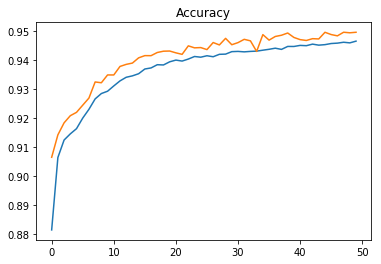

In [51]:
_ = plt.plot(history.history['acc'], label='Train')
_ = plt.plot(history.history['val_acc'], label='Validation')
_ = plt.title('Accuracy')

In [35]:
image_list = [f for f in glob.glob(base_path+'train-jpg/*.jpg')]
labels_df = pd.read_csv(base_path+'train_v2.csv')
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels_df['tags'].str.split()).astype(np.float32)

SPLIT = 0.2
dataset_size = len(image_list)
indices = list(range(dataset_size))
split = int(np.floor(SPLIT * dataset_size))

np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [36]:
mlb.classes_

array(['agriculture', 'artisinal_mine', 'bare_ground', 'blooming',
       'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation',
       'habitation', 'haze', 'partly_cloudy', 'primary', 'road',
       'selective_logging', 'slash_burn', 'water'], dtype=object)

In [15]:
def image_generator(image_list, labels, batch_size=64, selection_indices=None):
    
    while True:
        # Select files (paths/indices) for the batch
        if selection_indices is None:
            batch_paths = np.random.choice(a=np.arange(len(image_list)), 
                                            size=batch_size)
        else:
            batch_paths = np.random.choice(a=selection_indices, 
                                            size=batch_size)

        batch_input = []
        batch_output = [] 
        
        # Read in each input, perform preprocessing and get labels
        for index in batch_paths:
            image = cv2.resize(cv2.imread(image_list[index]), (32, 32)) / 255.
            # input = preprocess_input(image=input)
            batch_input += [ image ]
            batch_output += [ labels[index] ]
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

In [16]:
for i in range(4):
    X, y = next(image_generator(image_list, labels, batch_size=16, selection_indices=train_indices))
    print("i: ", X.shape, y.shape)

i:  (16, 32, 32, 3) (16, 17)
i:  (16, 32, 32, 3) (16, 17)
i:  (16, 32, 32, 3) (16, 17)
i:  (16, 32, 32, 3) (16, 17)


In [18]:
class KerasMetrics:
	def precision(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		predicted_positives = k.backend.sum(k.backend.round(k.backend.clip(y_pred, 0, 1)))
		precision = true_positives / (predicted_positives + k.backend.epsilon())
		return precision

	def recall(self, y_true, y_pred):
		true_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true * y_pred, 0, 1)))
		possible_positives = k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1)))
		recall = true_positives / (possible_positives + k.backend.epsilon())
		return recall

	def fbeta_score(self, y_true, y_pred, beta=2):
		if beta < 0:
			raise ValueError('The lowest choosable beta is zero (only precision).')

		if k.backend.sum(k.backend.round(k.backend.clip(y_true, 0, 1))) == 0:
			return 0

		p = self.precision(y_true, y_pred)
		r = self.recall(y_true, y_pred)
		bb = beta ** 2
		fbeta_score = (1 + bb) * (p * r) / (bb * p + r + k.backend.epsilon())
		return fbeta_score

In [19]:
keras_metrics = KerasMetrics()
# We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
optim = k.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy', keras_metrics.fbeta_score])

W0917 11:12:03.231876 140101946357568 deprecation.py:323] From /media/avemuri/DEV/software/anaconda3/envs/TF/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
BATCH_SIZE = 256
history = model.fit_generator(image_generator(image_list, labels, batch_size=BATCH_SIZE, 
                                              selection_indices=train_indices),
                              steps_per_epoch=len(train_indices)/BATCH_SIZE, epochs=10,
                              validation_data=image_generator(image_list, labels, 
                                                              batch_size=BATCH_SIZE, selection_indices=val_indices),
                              validation_steps=len(val_indices)/BATCH_SIZE)

Epoch 1/10
127/126 [==============================] - 57s 449ms/step - loss: 0.3437 - acc: 0.8967 - fbeta_score: 0.5956 - val_loss: 0.2567 - val_acc: 0.9064 - val_fbeta_score: 0.6084
Epoch 2/10
127/126 [==============================] - 53s 420ms/step - loss: 0.2607 - acc: 0.9046 - fbeta_score: 0.6027 - val_loss: 0.2576 - val_acc: 0.9067 - val_fbeta_score: 0.6090
Epoch 3/10
127/126 [==============================] - 53s 421ms/step - loss: 0.2623 - acc: 0.9034 - fbeta_score: 0.5988 - val_loss: 0.2581 - val_acc: 0.9064 - val_fbeta_score: 0.6083
Epoch 4/10
 98/126 [======================>.......] - ETA: 9s - loss: 0.2596 - acc: 0.9048 - fbeta_score: 0.6032

KeyboardInterrupt: 

In [22]:
class DataGenerator(k.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[idx] for idx in indexes]

        # Generate data
        #X, y = self.__data_generation(list_IDs_temp)

        #return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             X[i,] = np.load('data/' + ID + '.npy')

#             # Store class
#             y[i] = self.labels[ID]

#         return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
gen = DataGenerator()

In [ ]:
def csv_image_generator(inputPath, bs, lb, mode="train", aug=None):
	# open the CSV file for reading
	f = open(inputPath, "r")

	# loop indefinitely
	while True:
		# initialize our batches of images and labels
		images = []
		labels = []

		# keep looping until we reach our batch size
		while len(images) < bs:
			# attempt to read the next line of the CSV file
			line = f.readline()

			# check to see if the line is empty, indicating we have
			# reached the end of the file
			if line == "":
				# reset the file pointer to the beginning of the file
				# and re-read the line
				f.seek(0)
				line = f.readline()

				# if we are evaluating we should now break from our
				# loop to ensure we don't continue to fill up the
				# batch from samples at the beginning of the file
				if mode == "eval":
					break

			# extract the label and construct the image
			line = line.strip().split(",")
			label = line[0]
			image = np.array([int(x) for x in line[1:]], dtype="uint8")
			image = image.reshape((64, 64, 3))

			# update our corresponding batches lists
			images.append(image)
			labels.append(label)

		# one-hot encode the labels
		labels = lb.transform(np.array(labels))

		# if the data augmentation object is not None, apply it
		if aug is not None:
			(images, labels) = next(aug.flow(np.array(images),
				labels, batch_size=bs))

		# yield the batch to the calling function
		yield (np.array(images), labels)